# Libraries

In [1]:
# Backtrader Engine
import backtrader as bt

In [2]:
# Basics
#--Data Analytics
import numpy as np
import pandas as pd
import decimal
#--Statistics
import scipy.stats as stats
from scipy.stats import norm
#--Datetime
import datetime
import time
#--Operating System
import os
#--Plotting
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.dates as mdates
import seaborn as sns
#--Theme
from jupyterthemes import jtplot
jtplot.style(theme='onedork')

# Establish Datapath

In [3]:
# Datapath Function
def set_datapath(ticker):
    """
    This is to establish datapath
    
    Parameters
    ----------
    ticker : str
        Ticker or symbol of choosing
    
    Returns
    -------
    datapath : Return a unicode string representing the current working directory.
    
    files : Return a list of files in that folder
    """
    # Change Directory
    os.chdir(
        'C:\\Users\\asus\\Documents\\Python Projects\\Trading - Research and Backtest\\AAPL\\Databases'
    )
    # Get current directory
    datapath = os.getcwd()+'\\'
    # Store all files name in the folder to a list
    files = []
    for (dirpath, dirnames, filenames) in os.walk(datapath):
        files.extend(filenames)
        break
    print(files)
    return datapath, files

In [4]:
datapath, files = set_datapath('AAPL')

['AAPL-15min.csv', 'AAPL-1d.csv', 'AAPL-1min.csv', 'AAPL-1mo.csv', 'AAPL-1wk.csv', 'AAPL-2min.csv', 'AAPL-30min.csv', 'AAPL-3mo.csv', 'AAPL-5d.csv', 'AAPL-5min.csv', 'AAPL-60min.csv', 'AAPL-90min.csv', 'Extract_Indicator-Results.csv', 'welele', 'WilliamR-Results.csv']


# Create Strategy

In [39]:
class WilliamR(bt.Strategy):
    params = (
        ('target', 0.005),
        ('printlog', True),
        ('use_time_limit', True),
        ('william_period', 9),
        ('william_lower', -80),
        ('william_upper', -20),
        ('bband1_period', 20),
        ('bband1_stdev', 2),
        ('bband2_period', 20),
        ('bband2_stdev', 3),
        ('macd_me1', 6),
        ('macd_me2', 17),
        ('macd_sign', 9),
        ('adx_period', 5),
    )
    identity = params

    def log(self, txt, dt=None, h=None, doprint=False):
        """Logging function for this strategy"""
        # Log Date
        dt = dt or self.datas[0].datetime.date(0)
        # Log Time
        h = h or self.datas[0].datetime.time(0)
        # Print Log
        if self.params.printlog or doprint:
            print('%s %s, %s' % (dt.isoformat(), h.isoformat(), txt))

    def __init__(self):
        # Keep a reference to prices for data[0] in the series
        #--Open Price
        self.dataopen = self.datas[0].open
        #--High Price
        self.datahigh = self.datas[0].high
        #--Low Price
        self.datalow = self.datas[0].low
        #--Close Price
        self.dataclose = self.datas[0].close
        #--Volume
        self.datavolume = self.datas[0].volume

        # Keep track of pending order, buy price-commission, and call-put
        #--Order
        self.order = None
        #--Price
        self.price = None
        #--Commission
        self.commission = None
        #--Call-put
        self.call_put = None

        # Setup log file
        self.setup_log_file()
        
        #----------------------Indicators----------------------#
        if 1:  # William %R
            self.williamR = bt.indicators.WilliamsR(
                period=self.p.william_period,
                upperband=self.p.william_upper,
                lowerband=self.p.william_lower)
#         if 1:  # Support-Resistance
#             self.support_resist = bt.indicators.PivotPoint(self.data1,
#                                                            _autoplot=True)
        if 1:  # Bollinger Band
            self.bband1 = bt.indicators.BollingerBands(
                self.dataclose,
                period=self.p.bband1_period,
                devfactor=self.p.bband1_stdev)
            self.delayed_bband_top = self.bband1.lines.top(-1)
            self.delayed_bband_bot = self.bband1.lines.bot(-1)
            self.bband2 = bt.indicators.BollingerBands(
                self.dataclose,
                period=self.p.bband2_period,
                devfactor=self.p.bband2_stdev)
        if 1:  # MACD
            self.macd = bt.indicators.MACDHisto(period_me1=self.p.macd_me1,
                                                period_me2=self.p.macd_me2,
                                                period_signal=self.p.macd_sign)
            self.delayed_macd = self.macd.lines.histo(-1)
        if 1:  # ADX
            self.adx = bt.indicators.AverageDirectionalMovementIndex(
                period=self.p.adx_period)
            self.delayed_adx = self.adx.lines.adx(-1)
            sig = self.adx(-1)
            self.sig = self.adx.lines.adx - sig

    def next(self):
        # Log the next price
        self.log('Close: {:,.2f}'.format(self.dataclose[0]))
        # If there is a pending order, do not order another one
        if self.order:
            return
        # This is for one position at a time
        # Check if there is a position in the market
        if not self.position:  # Not in the market, open position
            time_limit = self.datas[0].datetime.time(0) < datetime.time(13, 0)

            def call_if():
                #----------------------William%R----------------------#
                call_rule1 = [
                    self.williamR.lines.percR[0] > self.p.william_upper
                ]
                #----------------------Support-Resistance----------------------#
#                 call_rule2 = [self.dataclose[0] > self.support_resist.lines.r1]
                call_rule2 = [True]
                #----------------------Bollinger Band----------------------#
                call_rule3 = [
                    (self.bband1.lines.top[0] > self.delayed_bband_top[0]),
                    (self.bband1.lines.bot[0] < self.delayed_bband_bot[0]),
                ]
                #----------------------MACD----------------------#
                call_rule4 = [
                    (self.macd.lines.histo[0] > self.delayed_macd[0]),
                    #(self.macd.lines.histo[0] > -0.2 and self.macd.lines.histo[0] < 0.2),
                    #(abs(self.macd.lines.histo[0]) > 0.1),
                ]
                #----------------------ADX----------------------#
                call_rule5 = [
                    (self.adx.lines.adx[0] > 20
                     and self.adx.lines.adx[0] <= 50),
                    (self.adx.lines.adx[0] > self.delayed_adx[0]),
                ]
                # Summary
                sum_rules = [
                    call_rule1, call_rule2, call_rule3, call_rule4, call_rule5
                ]
                #sum_rules = [call_rule5]
                call_rules = []
                for rules in sum_rules:
                    correct = all(rules)
                    call_rules.append(correct)
                return call_rules

            def put_if():
                #----------------------William%R----------------------#
                put_rule1 = [
                    self.williamR.lines.percR[0] < self.p.william_lower
                ]
                #----------------------Suppport-Resistance----------------------#
#                 put_rule2 = [self.dataclose[0] < self.support_resist.lines.s1]
                put_rule2 = [True]
                #----------------------Bollinger Band----------------------#
                put_rule3 = [
                    (self.bband1.lines.top[0] > self.delayed_bband_top[0]),
                    (self.bband1.lines.bot[0] < self.delayed_bband_bot[0]),
                ]
                #----------------------MACD----------------------#
                put_rule4 = [
                    (self.macd.lines.histo[0] < self.delayed_macd[0]),
                    #(self.macd.lines.histo[0] > -0.2),
                    #(abs(self.macd.lines.histo[0]) > 0.1),
                ]
                #----------------------ADX----------------------#
                put_rule5 = [
                    (self.adx.lines.adx[0] > 20
                     and self.adx.lines.adx[0] <= 25),
                    (self.adx.lines.adx[0] > self.delayed_adx[0]),
                ]
                # Summary
                sum_rules = [
                    put_rule1, put_rule2, put_rule3, put_rule4, put_rule5
                ]
                #sum_rules = [put_rule5]
                put_rules = []
                for rules in sum_rules:
                    correct = all(rules)
                    put_rules.append(correct)
                return put_rules

            if self.p.use_time_limit and time_limit:
                if all(call_if()):
                    self.log('BUY CALL CREATE ORDER: {:,.2f}'.format(
                        self.dataclose[0]))
                    self.order = self.buy()
                    self.call_put = 'buy call'
                elif all(put_if()):
                    self.log('BUY PUT CREATE ORDER: {:,.2f}'.format(
                        self.dataclose[0]))
                    self.order = self.sell()
                    self.call_put = 'buy put'
            elif not self.p.use_time_limit:
                if all(call_if()):
                    self.log('BUY CALL CREATE ORDER: {:,.2f}'.format(
                        self.dataclose[0]))
                    self.order = self.buy()
                    self.call_put = 'buy call'
                elif all(put_if()):
                    self.log('BUY PUT CREATE ORDER: {:,.2f}'.format(
                        self.dataclose[0]))
                    self.order = self.sell()
                    self.call_put = 'buy put'
        else:  # Close position
            time_limit = self.datas[0].datetime.time(0) < datetime.time(15, 0)
            if self.p.use_time_limit and time_limit:  # time
                if 1:  # default
                    target_achieved_call = [
                        ((self.target_p <= self.dataclose[0]) or
                         (self.target_p <= self.dataopen[0]))
                        or ((self.target_l >= self.dataclose[0]) or
                            (self.target_l >= self.dataopen[0]))
                    ]
                    target_achieved_put = [
                        ((self.target_p >= self.dataclose[0]) or
                         (self.target_p >= self.dataopen[0]))
                        or ((self.target_l <= self.dataclose[0]) or
                            (self.target_l <= self.dataopen[0]))
                    ]
                    if all(target_achieved_call
                           ) and self.call_put == 'buy call':
                        self.log('SELL CALL CREATE ORDER: {:,.2f}'.format(
                            self.dataclose[0]))
                        self.order = self.sell()
                        self.call_put = 'sell call'
                    elif all(target_achieved_put
                             ) and self.call_put == 'buy put':
                        self.log('SELL PUT CREATE ORDER: {:,.2f}'.format(
                            self.dataclose[0]))
                        self.order = self.buy()
                        self.call_put = 'sell put'
                if 0:  # reverse rule

                    def call_if():
                        #----------------------William%R----------------------#
                        call_rule1 = [
                            self.williamR.lines.percR[0] > self.p.william_upper
                        ]
                        #----------------------Support-Resistance----------------------#
                        call_rule2 = [
                            self.dataclose[0] > self.support_resist.lines.r1
                        ]
                        #----------------------Bollinger Band----------------------#
                        call_rule3 = [
                            (self.bband1.lines.top[0] >
                             self.delayed_bband_top[0]),
                            (self.bband1.lines.bot[0] <
                             self.delayed_bband_bot[0]),
                        ]
                        #----------------------MACD----------------------#
                        call_rule4 = [
                            (self.macd.lines.histo[0] > self.delayed_macd[0]),
                            #(self.macd.lines.histo[0] > -0.2 and self.macd.lines.histo[0] < 0.2),
                            #(abs(self.macd.lines.histo[0]) > 0.1),
                        ]
                        #----------------------ADX----------------------#
                        call_rule5 = [
                            (self.adx.lines.adx[0] > 20
                             and self.adx.lines.adx[0] <= 50),
                            (self.adx.lines.adx[0] > self.delayed_adx[0]),
                        ]
                        # Summary
                        sum_rules = [
                            call_rule1, call_rule2, call_rule3, call_rule4,
                            call_rule5
                        ]
                        #sum_rules = [call_rule5]
                        call_rules = []
                        for rules in sum_rules:
                            correct = all(rules)
                            call_rules.append(correct)
                        return call_rules

                    def put_if():
                        #----------------------William%R----------------------#
                        put_rule1 = [
                            self.williamR.lines.percR[0] < self.p.william_lower
                        ]
                        #----------------------Suppport-Resistance----------------------#
                        put_rule2 = [
                            self.dataclose[0] < self.support_resist.lines.s1
                        ]
                        #----------------------Bollinger Band----------------------#
                        put_rule3 = [
                            (self.bband1.lines.top[0] >
                             self.delayed_bband_top[0]),
                            (self.bband1.lines.bot[0] <
                             self.delayed_bband_bot[0]),
                        ]
                        #----------------------MACD----------------------#
                        put_rule4 = [
                            (self.macd.lines.histo[0] < self.delayed_macd[0]),
                            #(self.macd.lines.histo[0] > -0.2),
                            #(abs(self.macd.lines.histo[0]) > 0.1),
                        ]
                        #----------------------ADX----------------------#
                        put_rule5 = [
                            (self.adx.lines.adx[0] > 20
                             and self.adx.lines.adx[0] <= 25),
                            (self.adx.lines.adx[0] > self.delayed_adx[0]),
                        ]
                        # Summary
                        sum_rules = [
                            put_rule1, put_rule2, put_rule3, put_rule4,
                            put_rule5
                        ]
                        #sum_rules = [put_rule5]
                        put_rules = []
                        for rules in sum_rules:
                            correct = all(rules)
                            put_rules.append(correct)
                        return put_rules

                    if all(put_if()) and self.call_put == 'buy call':
                        self.log('SELL CALL CREATE ORDER: {:,.2f}'.format(
                            self.dataclose[0]))
                        self.order = self.sell()
                        self.call_put = 'sell call'
                    elif all(call_if()) and self.call_put == 'buy put':
                        self.log('SELL PUT CREATE ORDER: {:,.2f}'.format(
                            self.dataclose[0]))
                        self.order = self.buy()
                        self.call_put = 'sell put'
            elif not self.p.use_time_limit:
                if 1:  # default
                    target_achieved_call = [
                        ((self.target_p <= self.dataclose[0]) or
                         (self.target_p <= self.dataopen[0]))
                        or ((self.target_l >= self.dataclose[0]) or
                            (self.target_l >= self.dataopen[0]))
                    ]
                    target_achieved_put = [
                        ((self.target_p >= self.dataclose[0]) or
                         (self.target_p >= self.dataopen[0]))
                        or ((self.target_l <= self.dataclose[0]) or
                            (self.target_l <= self.dataopen[0]))
                    ]
                    if all(target_achieved_call
                           ) and self.call_put == 'buy call':
                        self.log('SELL CALL CREATE ORDER: {:,.2f}'.format(
                            self.dataclose[0]))
                        self.order = self.sell()
                        self.call_put = 'sell call'
                    elif all(target_achieved_put
                             ) and self.call_put == 'buy put':
                        self.log('SELL PUT CREATE ORDER: {:,.2f}'.format(
                            self.dataclose[0]))
                        self.order = self.buy()
                        self.call_put = 'sell put'
                if 0:  # reverse rule

                    def call_if():
                        #----------------------William%R----------------------#
                        call_rule1 = [
                            self.williamR.lines.percR[0] > self.p.william_upper
                        ]
                        #----------------------Support-Resistance----------------------#
                        call_rule2 = [
                            self.dataclose[0] > self.support_resist.lines.r1
                        ]
                        #----------------------Bollinger Band----------------------#
                        call_rule3 = [
                            (self.bband1.lines.top[0] >
                             self.delayed_bband_top[0]),
                            (self.bband1.lines.bot[0] <
                             self.delayed_bband_bot[0]),
                        ]
                        #----------------------MACD----------------------#
                        call_rule4 = [
                            (self.macd.lines.histo[0] > self.delayed_macd[0]),
                            #(self.macd.lines.histo[0] > -0.2 and self.macd.lines.histo[0] < 0.2),
                            #(abs(self.macd.lines.histo[0]) > 0.1),
                        ]
                        #----------------------ADX----------------------#
                        call_rule5 = [
                            (self.adx.lines.adx[0] > 20
                             and self.adx.lines.adx[0] <= 50),
                            (self.adx.lines.adx[0] > self.delayed_adx[0]),
                        ]
                        # Summary
                        sum_rules = [
                            call_rule1, call_rule2, call_rule3, call_rule4,
                            call_rule5
                        ]
                        #sum_rules = [call_rule5]
                        call_rules = []
                        for rules in sum_rules:
                            correct = all(rules)
                            call_rules.append(correct)
                        return call_rules

                    def put_if():
                        #----------------------William%R----------------------#
                        put_rule1 = [
                            self.williamR.lines.percR[0] < self.p.william_lower
                        ]
                        #----------------------Suppport-Resistance----------------------#
                        put_rule2 = [
                            self.dataclose[0] < self.support_resist.lines.s1
                        ]
                        #----------------------Bollinger Band----------------------#
                        put_rule3 = [
                            (self.bband1.lines.top[0] >
                             self.delayed_bband_top[0]),
                            (self.bband1.lines.bot[0] <
                             self.delayed_bband_bot[0]),
                        ]
                        #----------------------MACD----------------------#
                        put_rule4 = [
                            (self.macd.lines.histo[0] < self.delayed_macd[0]),
                            #(self.macd.lines.histo[0] > -0.2),
                            #(abs(self.macd.lines.histo[0]) > 0.1),
                        ]
                        #----------------------ADX----------------------#
                        put_rule5 = [
                            (self.adx.lines.adx[0] > 20
                             and self.adx.lines.adx[0] <= 25),
                            (self.adx.lines.adx[0] > self.delayed_adx[0]),
                        ]
                        # Summary
                        sum_rules = [
                            put_rule1, put_rule2, put_rule3, put_rule4,
                            put_rule5
                        ]
                        #sum_rules = [put_rule5]
                        put_rules = []
                        for rules in sum_rules:
                            correct = all(rules)
                            put_rules.append(correct)
                        return put_rules

                    if all(put_if()) and self.call_put == 'buy call':
                        self.log('SELL CALL CREATE ORDER: {:,.2f}'.format(
                            self.dataclose[0]))
                        self.order = self.sell()
                        self.call_put = 'sell call'
                    elif all(call_if()) and self.call_put == 'buy put':
                        self.log('SELL PUT CREATE ORDER: {:,.2f}'.format(
                            self.dataclose[0]))
                        self.order = self.buy()
                        self.call_put = 'sell put'
        with open(self.logfile, 'a+') as f:
            log = "{},{},{},{},{},{},{}\n".format(self.datas[0],self.dataopen[0],self.datahigh[0],self.datalow[0],self.dataclose[0],self.datavolume[0],self.williamR.lines.percR[0])
            f.write(log)
        
    def notify_order(self, order):
        # If Buy and/or Sell submitted then accepted by broker - Nothing to do
        if order.status in [order.Submitted, order.Accepted]:
            return
        #Check if an order is completed
        if order.status in [order.Completed]:
            if self.call_put == 'buy call' and order.isbuy():
                self.log('BUY CALL EXECUTED, Price: {:,.2f}'.format(
                    order.executed.price))
                self.target_p = order.executed.price * (1 + self.p.target)
                self.target_l = order.executed.price * (1 - self.p.target * 10)
            elif self.call_put == 'sell call' and order.issell():
                self.log('SELL CALL EXECUTED, Price: {:,.2f}'.format(
                    order.executed.price))
            elif self.call_put == 'buy put' and order.issell():
                self.log('BUY PUT EXECUTED, Price: {:,.2f}'.format(
                    order.executed.price))
                self.target_p = order.executed.price * (1 - self.p.target)
                self.target_l = order.executed.price * (1 + self.p.target)
            elif self.call_put == 'sell put' and order.isbuy():
                self.log('SELL PUT EXECUTED, Price: {:,.2f}'.format(
                    order.executed.price))
        elif order.status in [order.Cancelled, order.Margin, order.Rejected]:
            self.log('ORDER CANCELLED', doprint=self.p.print)
        # Write down that there is no order
        self.order = None
        return self.target_p, self.target_l

    def notify_trade(self, trade):
        if not trade.isclosed:
            return
        self.log('OPERATION PROFIT/LOSS, GROSS: {:,.2f}'.format(trade.pnl))
    
    def setup_log_file(self):
        """Function to setup log files.
        """
        cn = self.__class__.__name__
        self.logfile ='{}-Results.csv'.format(cn)

        #Write the header to the trade log.
        log_header = 'Datetime,Open,High,Low,Close,Volume,Signal'
        with open(self.logfile, 'w') as file:
            file.write(log_header + "\n")

In [116]:
class Extract_Indicator(bt.Strategy):
    params = dict(william_period=9,
                  william_lower=-80,
                  william_upper=-20,
                  bband1_period=20,
                  bband1_stdev=2,
                  bband2_period=20,
                  bband2_stdev=3,
                  macd_me1=6,
                  macd_me2=17,
                  macd_sign=9,
                  adx_period=5)

    def __init__(self):
        """Initializa Indicators and Data"""
        # WilliamR
        self.williamR = bt.indicators.WilliamsR(period=self.p.william_period,
                                                upperband=self.p.william_upper,
                                                lowerband=self.p.william_lower)
        
        # Bollinger's Band
        self.bband1 = bt.indicators.BollingerBands(
            self.data.close,
            period=self.p.bband1_period,
            devfactor=self.p.bband1_stdev)
        self.delayed_bband_top = self.bband1.lines.top(-1)
        self.delayed_bband_bot = self.bband1.lines.bot(-1)
        self.bband2 = bt.indicators.BollingerBands(
            self.data.close,
            period=self.p.bband2_period,
            devfactor=self.p.bband2_stdev)
        
        # MACD
        self.macd = bt.indicators.MACDHisto(period_me1=self.p.macd_me1,
                                period_me2=self.p.macd_me2,
                                period_signal=self.p.macd_sign)
        self.delayed_macd = self.macd.lines.histo(-1)

        # ADX
        self.adx = bt.indicators.AverageDirectionalMovementIndex(
        period=self.p.adx_period)
        self.delayed_adx = self.adx.lines.adx(-1)
        sig = self.adx(-1)
        self.sig = self.adx.lines.adx - sig
        
        self.setup_log_file()

    def next(self):
        dt = self.datas[0].datetime.datetime()  # Datetime
        bar = len(self.datas[0])  # Bar
        o = self.datas[0].open[0]  # Open
        h = self.datas[0].high[0]  # High
        l = self.datas[0].low[0]  # Low
        c = self.datas[0].close[0]  # Close
        v = self.datas[0].volume[0]  # Volume

        with open(self.logfile, 'a+') as f:
            log = "{},{},{},{},{},{},{}\n".format(dt, o, h, l, c, v,
                                                  self.williamR.lines.percR[0])
            f.write(log)

    def setup_log_file(self):
        """Function to setup log files.
        """
        cn = self.__class__.__name__
        self.logfile = '{}-Results.csv'.format(cn)

        #Write the header to the trade log.
        log_header = 'Datetime,Open,High,Low,Close,Volume,WilliamR'
        with open(self.logfile, 'w') as file:
            file.write(log_header + "\n")

In [117]:
if __name__ == '__main__':
    # Create a cerebro entity
    cerebro = bt.Cerebro()

    # Add a strategy
    cerebro.addstrategy(Extract_Indicator)

    # Datas are in a subfolder of the samples. Need to find where the script is
    # because it could have been called from anywhere
#     modpath = os.path.dirname(os.path.abspath(sys.argv[0]))
#     datapath = os.path.join(modpath, '../../datas/orcl-1995-2014.txt')

    # Create a Data Feed
    datafeed = bt.feeds.GenericCSVData(dataname = datapath+files[0],
                                       timeframe = bt.TimeFrame.Minutes,
                                       compression = 5,
                                       sessionstart = datetime.time(9, 35, 0),
                                       sessionend = datetime.time(15, 30, 0),
                                       reverse = False, datetime = 1, time = 10,
                                       high = 3, low = 4, open = 3, close = 5, volume = 7, openinterest = -1,
                                       nullvalue = 0.0, #fromdate = datetime.datetime(2020, 4, 15), todate = datetime.datetime(2020, 4, 16),
                                       dtformat = ('%Y-%m-%d'), tmformat = ('%H:%M:%S')
                                      ) # 

    # Add the Data Feed to Cerebro
    cerebro.adddata(datafeed)

    # Set our desired cash start
    cerebro.broker.setcash(100000.0)

    # Print out the starting conditions
    print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

    # Run over everything
    cerebro.run()

    # Print out the final result
    print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 100000.00
Final Portfolio Value: 100000.00


# New

In [5]:
import btalib

In [6]:
df_15min = pd.read_csv(datapath+files[0], index_col='Datetime')

In [16]:
sma = btalib.sma(df_15min['Adj Close'], period=40)
df_15min['SMA'] = sma.df

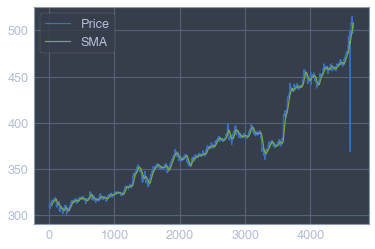

In [17]:
plt.plot(df_15min['Adj Close'].values, label='Price')
plt.plot(df_15min['SMA'].values, label='SMA')
plt.legend()
plt.show()